In [ ]:
import os
import random
import cv2 as cv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
import nbformat
from PIL import Image

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/animals'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['panda', 'cats', 'dogs']


In [ ]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv.imread(os.path.join(path, img))

        # Resize image to 32x32 using bilinear interpolation
        img_arr = cv.resize(img_arr, (32, 32), interpolation=cv.INTER_AREA)

        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 1000/1000 [00:28<00:00, 34.96it/s]

3000


In [ ]:
random.shuffle(TRAIN_DATA)

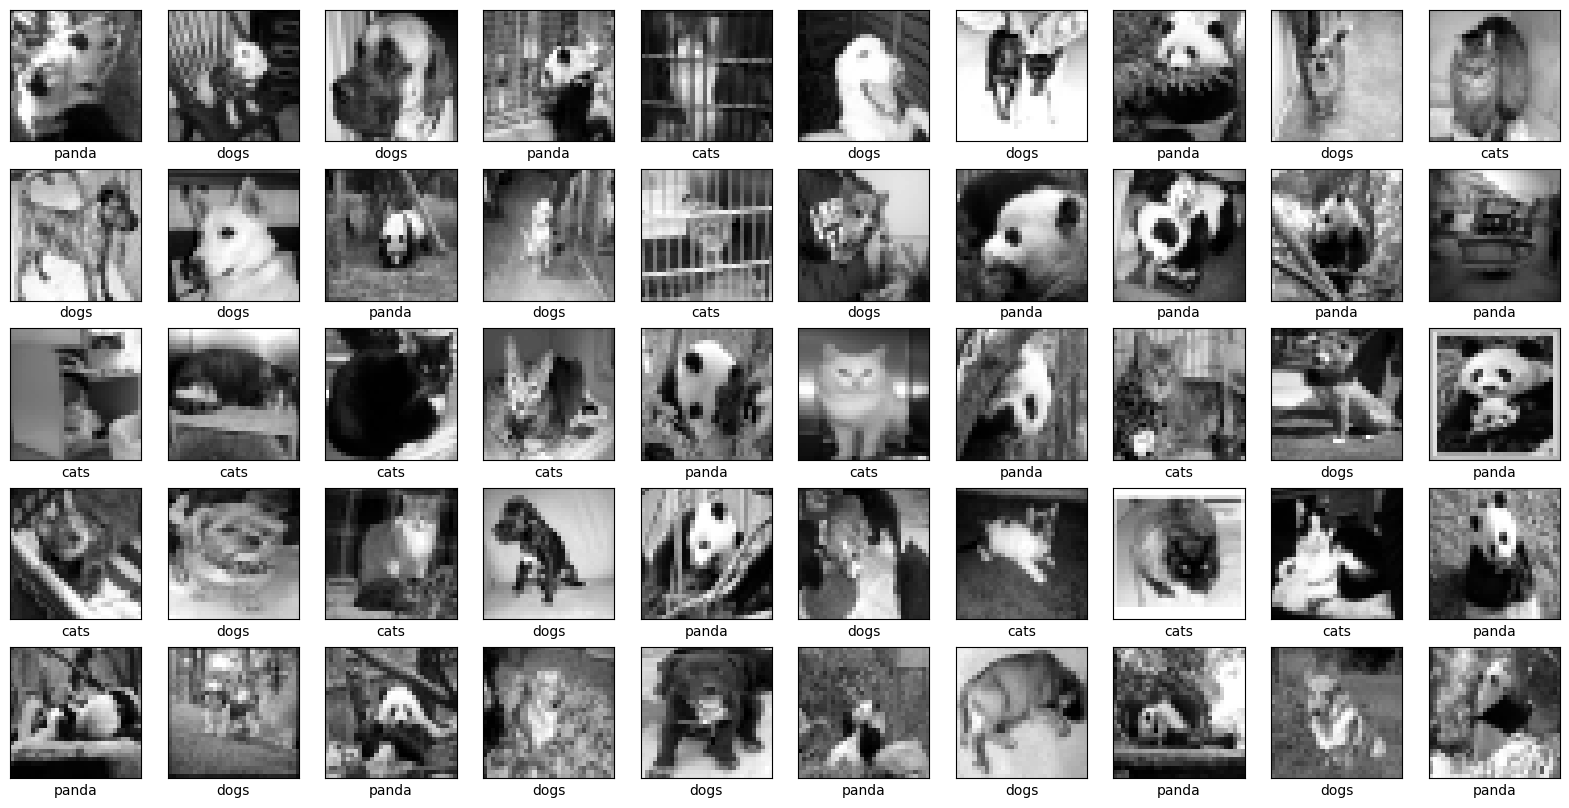

In [ ]:
plt.figure(figsize=(20,10))

for i in range(50):
  plt.subplot(5, 10, i+1)
  image = TRAIN_DATA[i][0]
  image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert image to grayscale
  plt.imshow(image_gray, cmap="gray")
  plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
  plt.xticks([])
  plt.yticks([])
  plt.axis()
  if i == 50:
    break
plt.show()

In [ ]:
f1 = TRAIN_DATA[0:600]
f2 = TRAIN_DATA[600:1200]
f3 = TRAIN_DATA[1200:1800]
f4 = TRAIN_DATA[1800:2400]
f5 = TRAIN_DATA[2400:3000]

In [ ]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]


In [ ]:
top_filter = 20
def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold):
        temp_dist_list = []
        for train in train_fold:
            l1_dist = np.sum(np.abs(valid[0]-train[0]))
            l2_dist = np.sqrt(np.sum(valid[0]-train[0]**2))
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])
        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]


In [ ]:
k_range = 20
def cal_accuracy(dist_result, dist_term):
    k_accuracies = []
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:
                    img_accuracy += 1
            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies

In [ ]:
dist_by_fold = []
import math
for i in range(1,6,1):
    if i==1:
        train = f1+f2+f3+f4
        validation = f5
    elif i==2:
        train = f1+f2+f3+f5
        validation = f4
    elif i==3:
        train = f1+f2+f4+f5
        validation = f3
    elif i==4:
        train = f1+f3+f4+f5
        validation = f2
    elif i==5:
        train = f2+f3+f4+f5
        validation = f1

    dist_by_fold.append(distance_calc(train, validation))

100%|██████████| 600/600 [00:43<00:00, 13.65it/s]


In [ ]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])


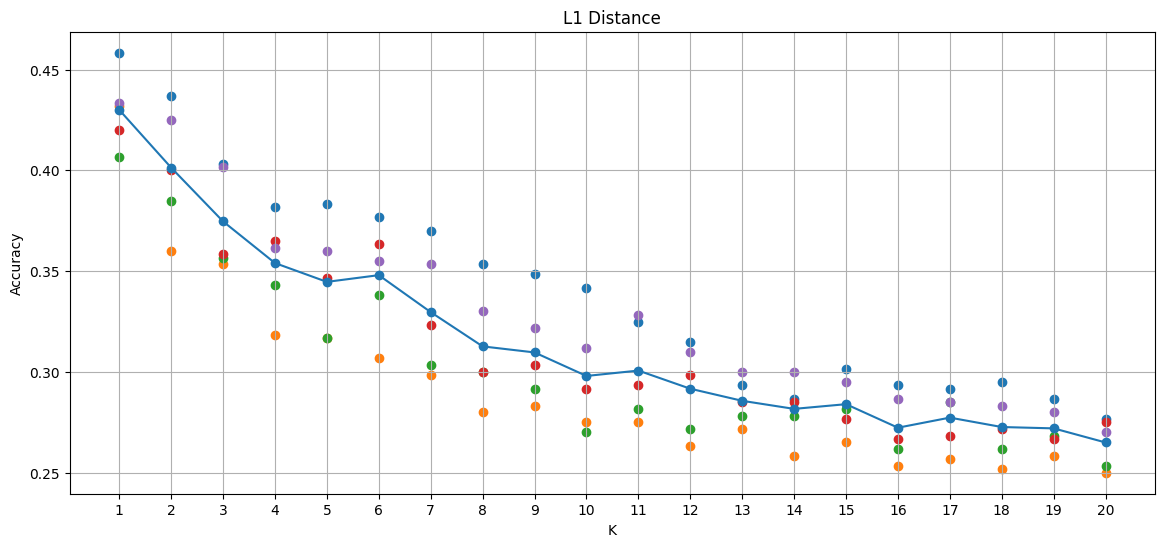

In [ ]:
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = fold[0]
  plt.scatter(x_list, y_list)
arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend, fmt='-o')
plt.title('L1 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

<Figure size 1400x600 with 0 Axes>

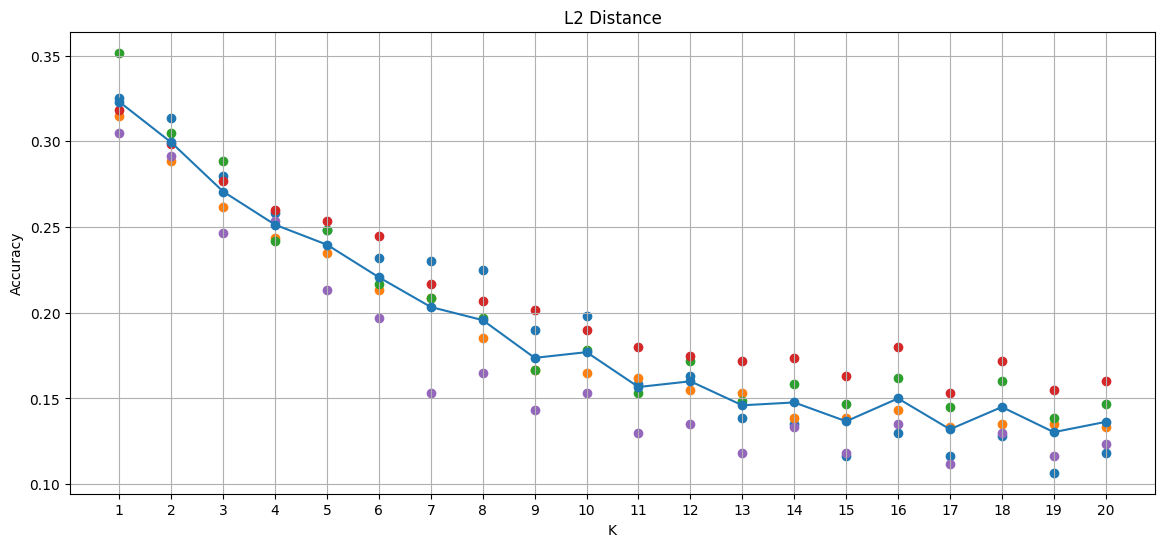

In [ ]:
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = fold[1]
  plt.scatter(x_list, y_list)
arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')
plt.title('L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()


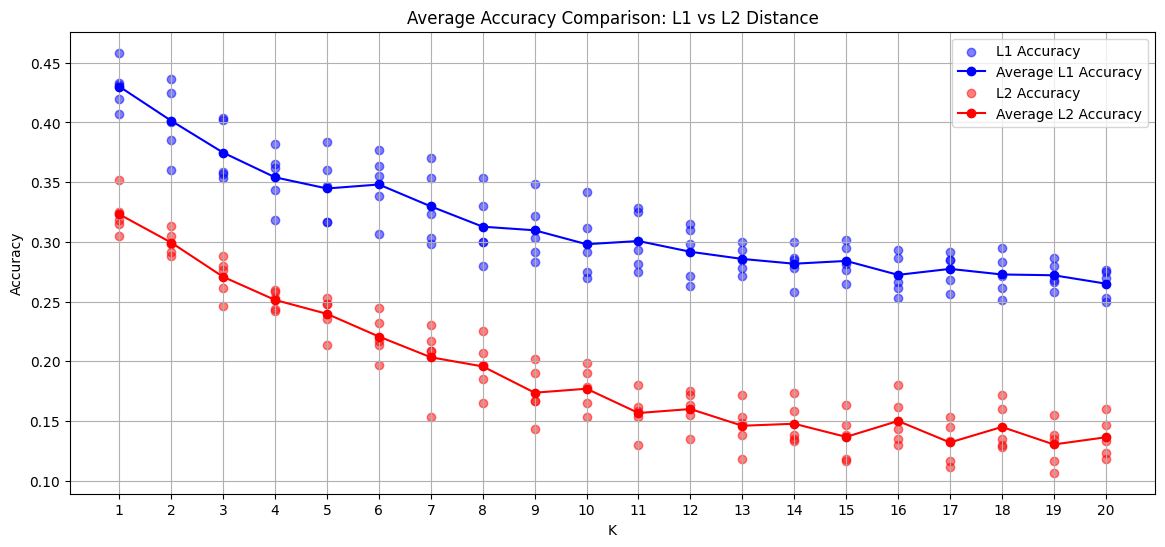

In [ ]:
x_list = list(range(1, k_range + 1))
plt.figure(figsize=(14, 6))

# Calculate average accuracy across all folds for each k value
l1_arr = [[fold[0][i] for fold in accuracies] for i in range(k_range)]
l2_arr = [[fold[1][i] for fold in accuracies] for i in range(k_range)]

l1_average_accuracy = [np.mean(a) for a in l1_arr]
l2_average_accuracy = [np.mean(a) for a in l2_arr]

# Plotting the L1 accuracy
for fold in accuracies:
    plt.scatter(x_list, fold[0], color='blue', alpha=0.5, label='L1 Accuracy' if fold == accuracies[0] else "")

# Plotting the trend line (average accuracy for L1)
plt.plot(x_list, l1_average_accuracy, '-o', label='Average L1 Accuracy', color='blue')

# Plotting the L2 accuracy
for fold in accuracies:
    plt.scatter(x_list, fold[1], color='red', alpha=0.5, label='L2 Accuracy' if fold == accuracies[0] else "")

# Plotting the trend line (average accuracy for L2)
plt.plot(x_list, l2_average_accuracy, '-o', label='Average L2 Accuracy', color='red')

plt.title('Average Accuracy Comparison: L1 vs L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Discussion:The graph is a line chart comparing the average accuracy of L1 and L2 distances in an image classification task using the CIFAR-10 dataset with 5-fold cross-validation. The x-axis represents the value of K, and the y-axis represents accuracy values. The Manhattan distance metric proved better with the highest accuracy reaching 46% when k=1. On the other hand, for Euclidean, the accuracy peaked at 36% when k=1.Here L1 distance or Manhattan Distance performed better than L2 distance or Euclidean Distance. L1 distance is more robust to outliers iin the data compared to L2 distance. Also, calculating L1 distance computationally more efficient than L2 distance, becaue it takes the absolute differeneces rather than squarring and taking square roots. L1 distance also can be used to identify features in the data, by weighting the features according to their L1 distance, KNN can focus on the deatures that are most predective**

**Limitation:The use of grayscale images, which reduces the amount of feature information, potentially impacting classification accuracy. The simplicity of the KNN model, which heavily relies on the choice of K and distance metric, may not effectively capture complex patterns in the data. Additionally, while 5-fold cross-validation is a good practice, it might not always evenly distribute class samples, leading to biased results.**

 **Improvement: Enhance feature extraction to retain more discriminative information in grayscale images, and explore advanced models like CNNs for better performance. Additionally, optimize K values and distance metrics for improved accuracy indicating that smaller values of K are more effective for this dataset and distance metric combination**

Top 5 Predictions for L1 Distance:
Prediction 1: Class 'panda' with L1 distance 0.00
Prediction 2: Class 'cats' with L1 distance 853.21
Prediction 3: Class 'dogs' with L1 distance 939.52
Prediction 4: Class 'panda' with L1 distance 962.04
Prediction 5: Class 'cats' with L1 distance 964.74

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'panda' with L2 distance 0.00
Prediction 2: Class 'cats' with L2 distance 310.30
Prediction 3: Class 'cats' with L2 distance 311.93
Prediction 4: Class 'cats' with L2 distance 312.25
Prediction 5: Class 'panda' with L2 distance 312.59


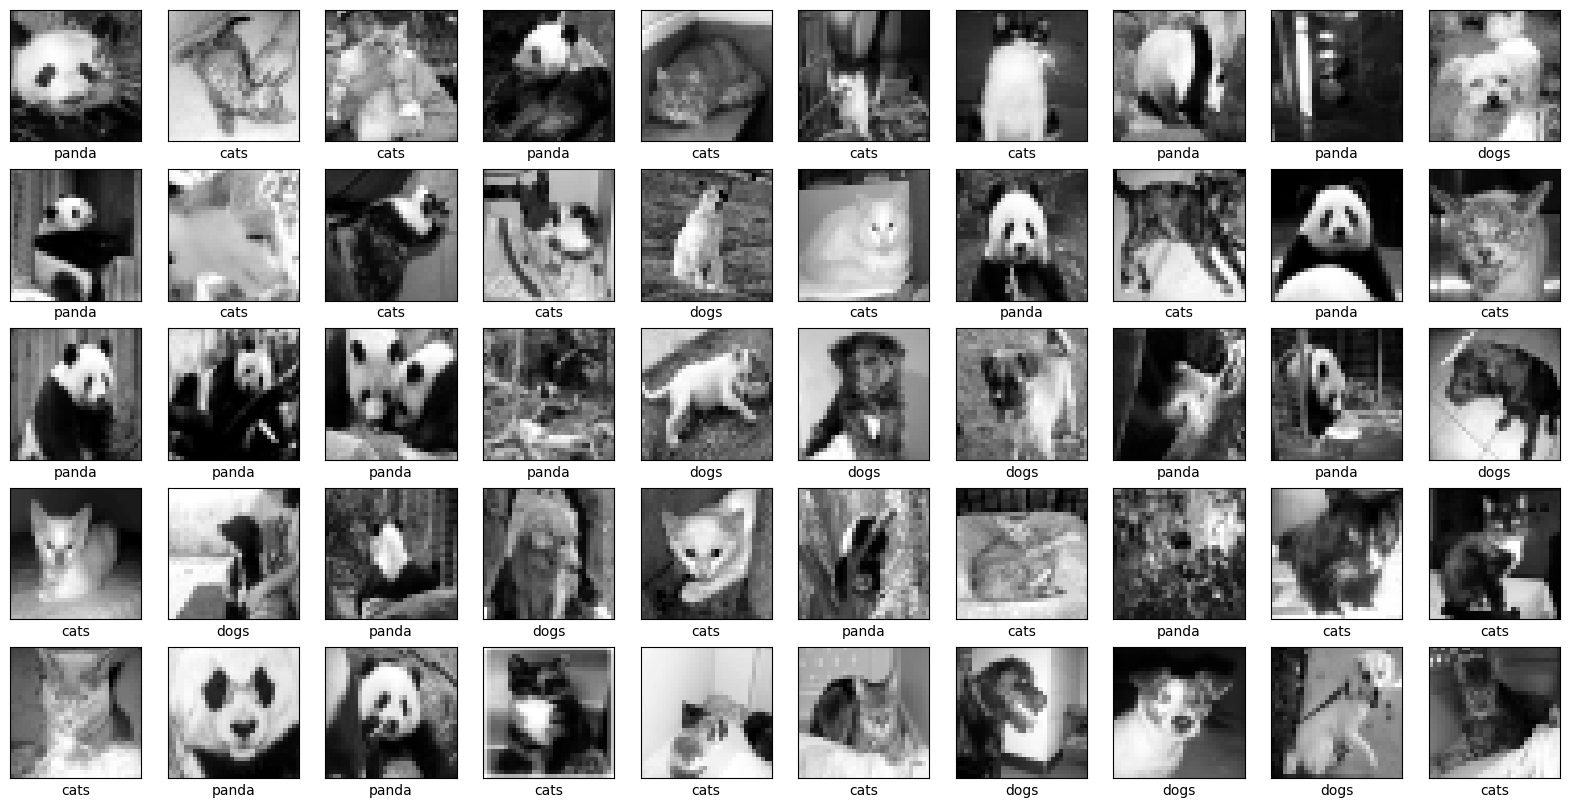

In [ ]:
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 49:
        break
test_images = []

for i in range(1000):
    test_image = TRAIN_DATA[i][0]
    test_image_gray = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)
    test_images.append(test_image_gray)

print("Top 5 Predictions for L1 Distance:")
for test_image_gray in test_images:
    distances1 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist1 = l1_dist(test_image_gray, train_image_gray)
        distances1.append((dist1, class_num))
    distances1.sort(key=lambda x: x[0])

    for i, (dist1, class_num) in enumerate(distances1[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")
    break


print("\nTop 5 Predictions for L2 Distance:")
for test_image_gray in test_images:
    distances2 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray, train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    for i, (dist2, class_num) in enumerate(distances2[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")
    break

